https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html

In [14]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

In [3]:
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

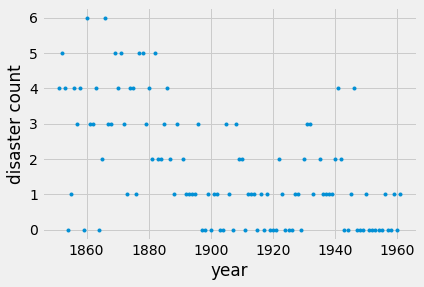

In [9]:
fig, ax = plt.subplots()
ax.plot(years, disaster_data, marker=".", linestyle="")
ax.set_ylabel("disaster count")
ax.set_xlabel("year")
plt.show()

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model,


\begin{split}\begin{aligned}
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases}
   e, & \text{if } t \le s \\
   l, & \text{if } t \gt s
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)
\end{aligned}\end{split}

the parameters are defined as follows: 

$D_t$: The number of disasters in year  $t$ 

$r_t$: The rate parameter of the Poisson distribution of disasters in year

$s$: The year in which the rate parameter changes (the switchpoint).

$e$: The rate parameter before the switchpoint

$l$: The rate parameter after the switchpoint

$t_l\, t_h$: The lower and upper boundaries of year

This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable rate.

In [10]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )
    # testval is the initial value for the distribution, to avoid using illegal values

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/harima/anaconda3/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Missing values are handled transparently by passing a MaskedArray or a pandas.DataFrame with NaN values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we will sample using a Metroplis step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC3 automatically assigns the correct sampling algorithms.

In [11]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [15]:
with disaster_model:
    idata = az.from_pymc3(trace)

In [16]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

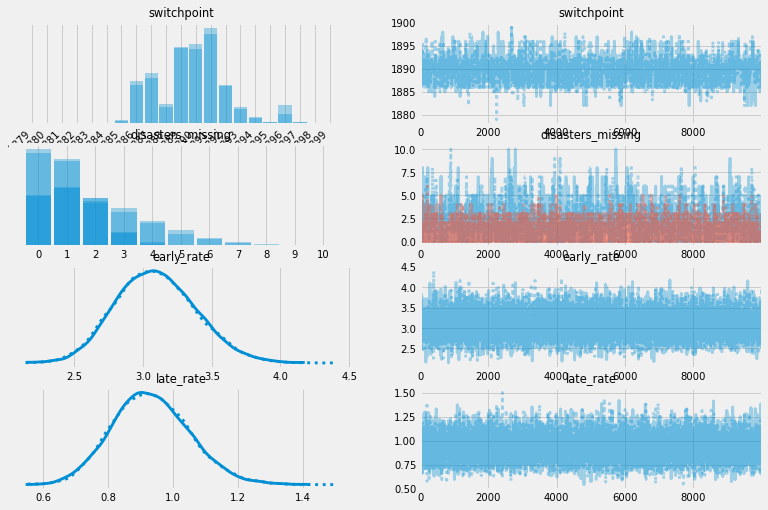

In [17]:
with disaster_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

The following plot shows the switch point as an orange vertical line, together with its HPD interval (highest probability density) as a semitransparent band. The dashed black line shows the accident rate.

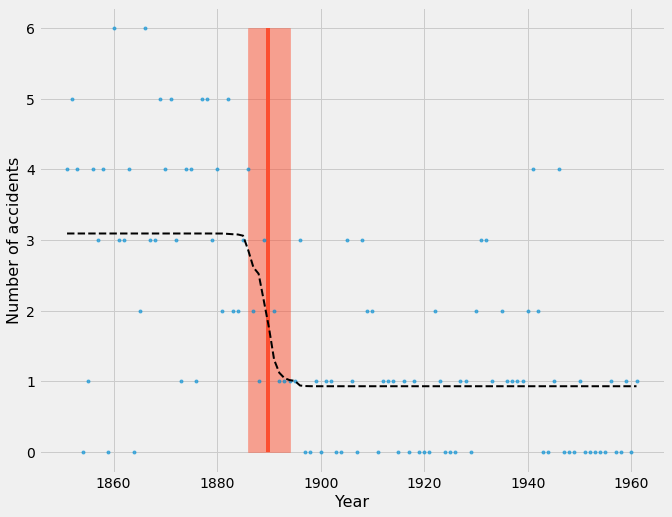

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2)